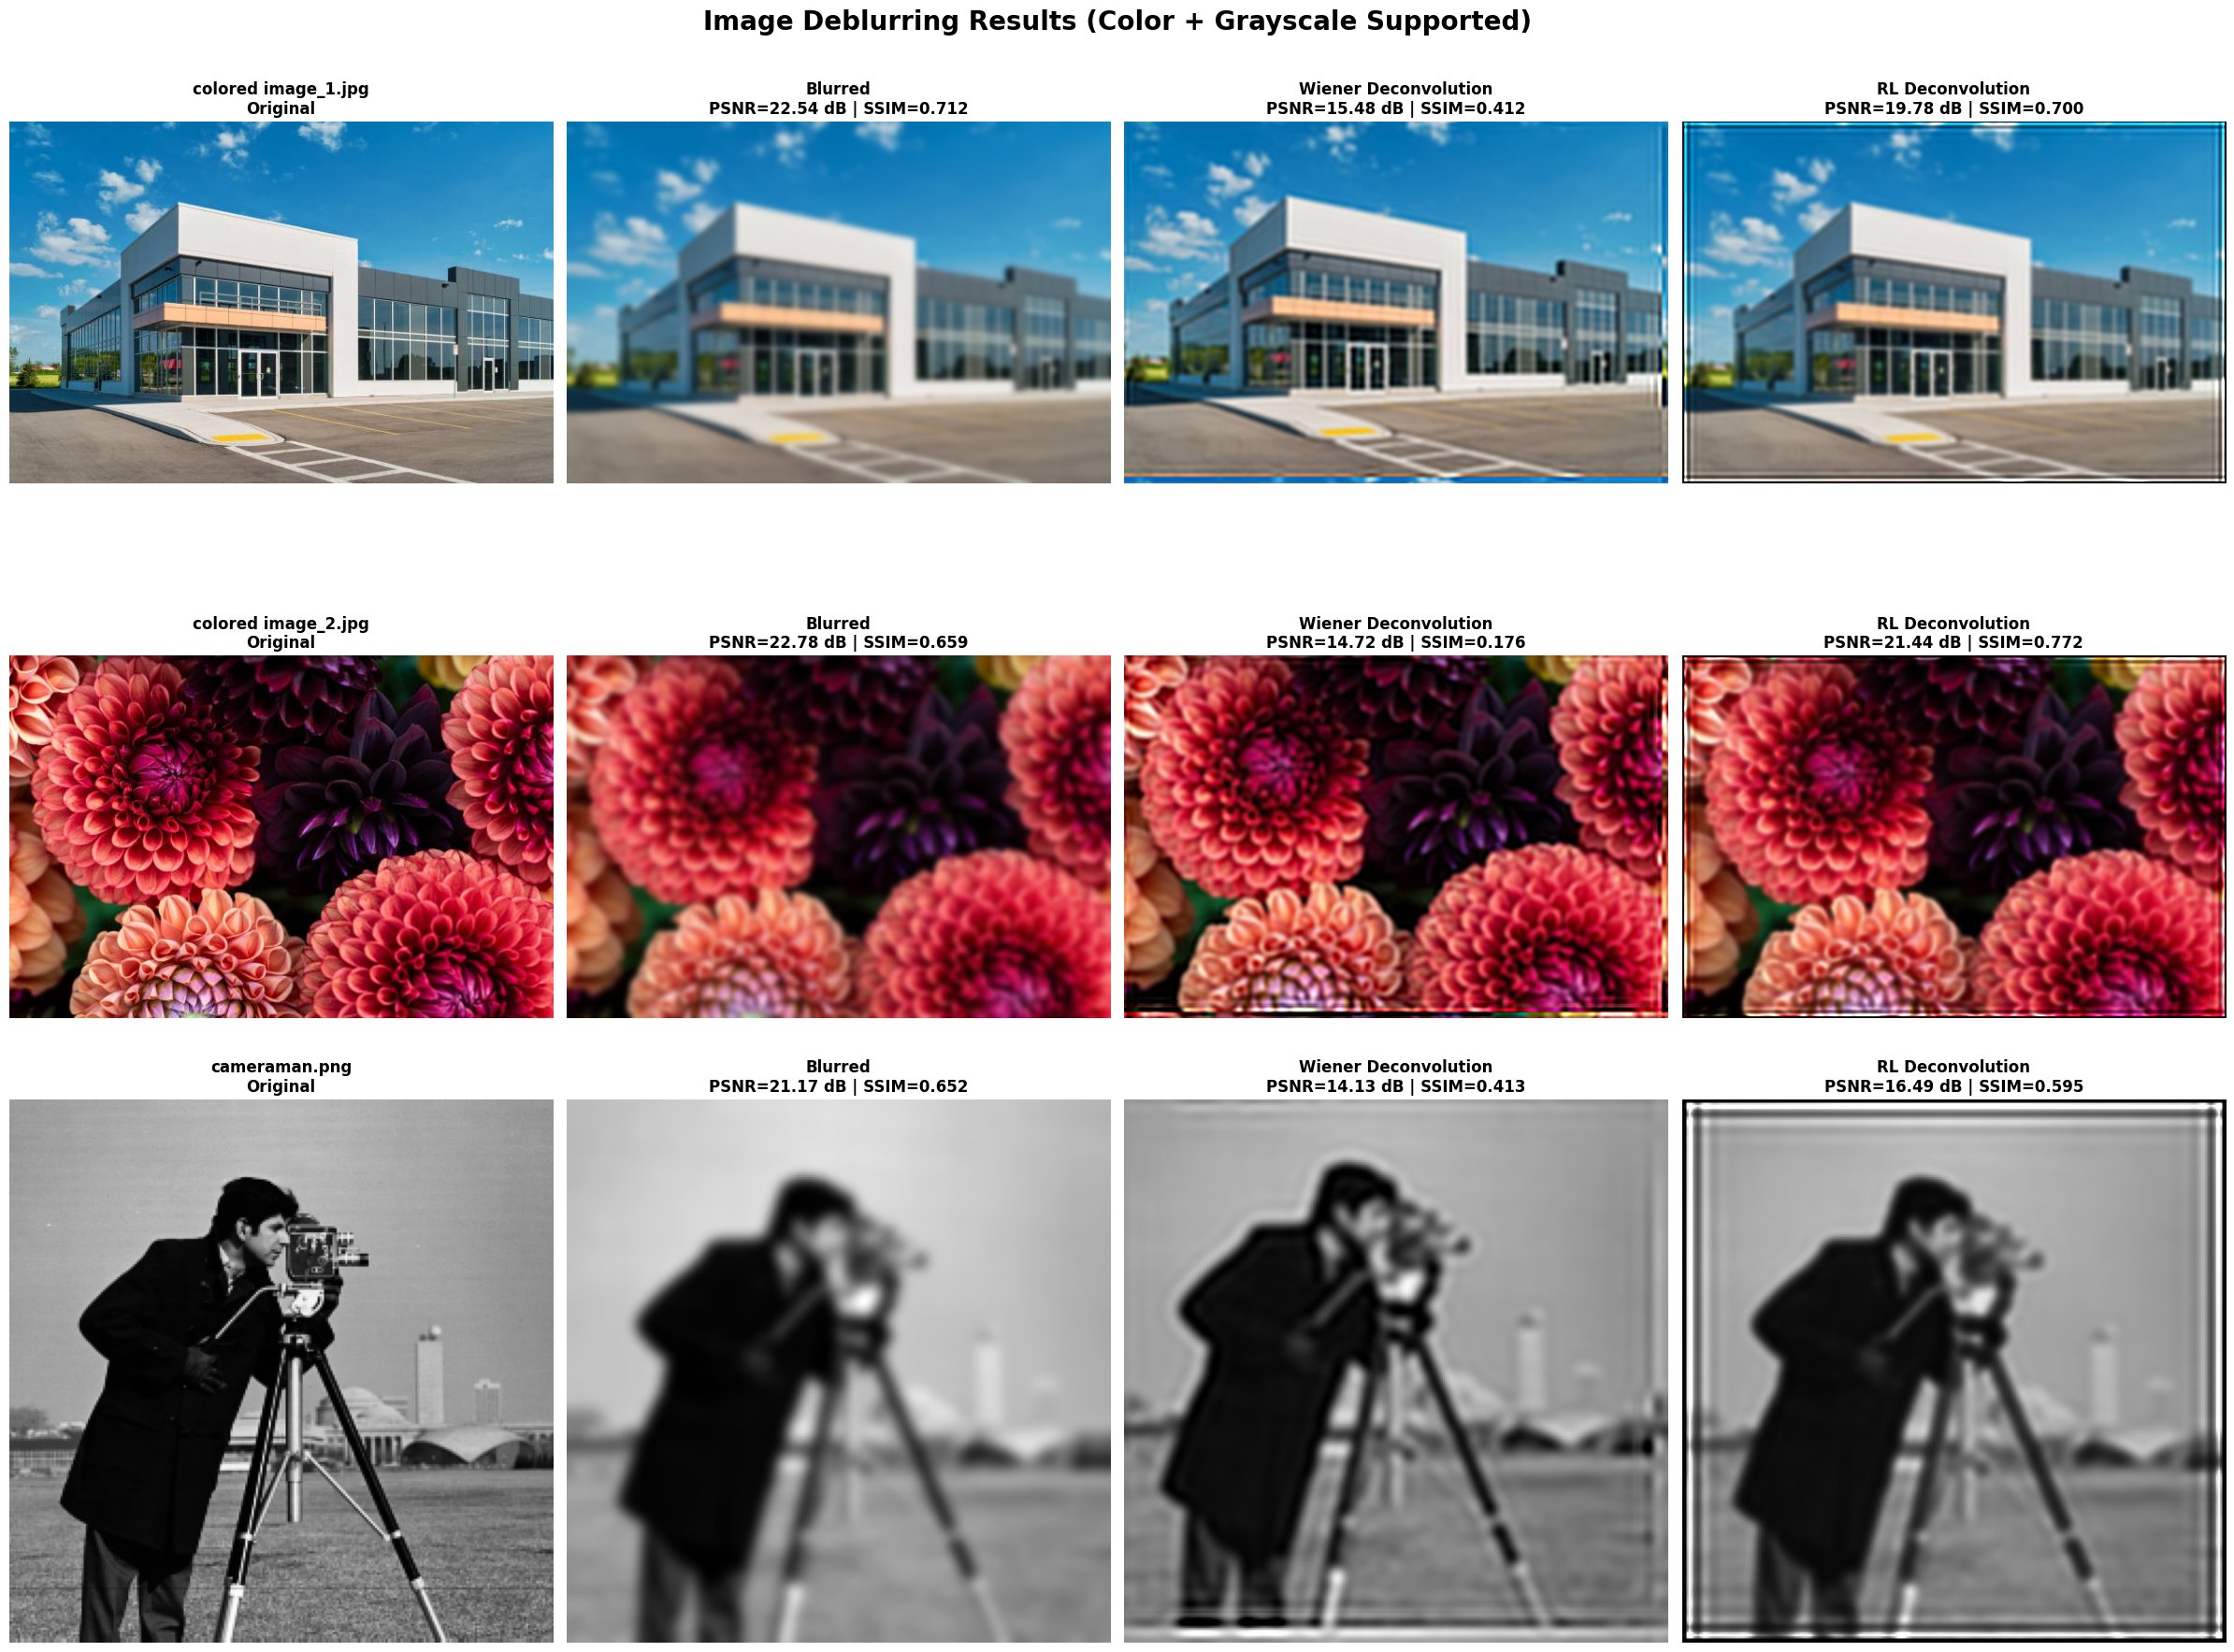

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, restoration, img_as_float
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from scipy.signal import convolve2d


# ---------- Load image ----------
def load_image(image_path):
    img = img_as_float(io.imread(image_path))
    return img


# ---------- Gaussian PSF ----------
def make_gaussian_psf(size, sigma):
    ax = np.arange(-(size//2), size//2 + 1)
    xx, yy = np.meshgrid(ax, ax)
    psf = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    psf /= psf.sum()
    return psf


# ---------- Blur ----------
def blur_image(image, psf):
    if image.ndim == 2:
        return convolve2d(image, psf, mode='same', boundary='symm')

    blurred = np.zeros_like(image)
    for c in range(3):
        blurred[:, :, c] = convolve2d(image[:, :, c], psf, mode='same', boundary='symm')
    return blurred


# ---------- Wiener Deconvolution ----------
def _wiener_single(img, psf, K):
    img_fft = np.fft.fft2(img)
    psf_fft = np.fft.fft2(psf, s=img.shape)
    psf_fft_conj = np.conj(psf_fft)
    wf = psf_fft_conj / (np.abs(psf_fft)**2 + K)
    result = np.real(np.fft.ifft2(img_fft * wf))
    return np.clip(result, 0, 1)


def wiener_deconvolution(img, psf, K=0.01):
    if img.ndim == 2:
        return _wiener_single(img, psf, K)

    restored = np.zeros_like(img)
    for c in range(3):
        restored[:, :, c] = _wiener_single(img[:, :, c], psf, K)
    return restored


# ---------- RL Deconvolution ----------
def blind_deconvolution(img, psf, iterations=40):
    if img.ndim == 2:
        return restoration.richardson_lucy(img, psf, num_iter=iterations)

    restored = np.zeros_like(img)
    for c in range(3):
        restored[:, :, c] = restoration.richardson_lucy(img[:, :, c], psf, num_iter=iterations)
    return np.clip(restored, 0, 1)


# ---------- Metrics ----------
def compute_metrics(original, test):
    if original.ndim == 3:
        original = original.mean(axis=2)
        test = test.mean(axis=2)
    psnr = peak_signal_noise_ratio(original, test, data_range=1)
    ssim = structural_similarity(original, test, data_range=1)
    return psnr, ssim


# ---------- Process a single image ----------
def process_image(image_path):
    img = load_image(image_path)

    # PSF
    psf = make_gaussian_psf(size=15, sigma=3)
    blurred = blur_image(img, psf)

    # Deconvolution
    wiener = wiener_deconvolution(blurred, psf)
    psf2 = make_gaussian_psf(size=13, sigma=2.5)
    blind = blind_deconvolution(blurred, psf2)

    # Metrics for Blurred, Wiener, RL
    blurred_m = compute_metrics(img, blurred)
    wiener_m = compute_metrics(img, wiener)
    blind_m = compute_metrics(img, blind)

    return img, blurred, wiener, blind, blurred_m, wiener_m, blind_m


# ---------- MAIN ----------
def main():
    image_list = [
        "colored image_1.jpg",
        "colored image_2.jpg",
        "cameraman.png"
    ]

    fig, axes = plt.subplots(3, 4, figsize=(24, 18))
    fig.suptitle("Image Deblurring Results (Color + Grayscale Supported)", fontsize=20, fontweight='bold')

    for row, img_path in enumerate(image_list):
        original, blurred, wiener, blind, blur_m, wnr_m, bdc_m = process_image(img_path)

        images = [original, blurred, wiener, blind]
        titles = [
            f"{img_path}\nOriginal",
            f"Blurred\nPSNR={blur_m[0]:.2f} dB | SSIM={blur_m[1]:.3f}",
            f"Wiener Deconvolution\nPSNR={wnr_m[0]:.2f} dB | SSIM={wnr_m[1]:.3f}",
            f"RL Deconvolution\nPSNR={bdc_m[0]:.2f} dB | SSIM={bdc_m[1]:.3f}"
        ]

        for col in range(4):
            ax = axes[row, col]
            ax.imshow(images[col], cmap='gray' if images[col].ndim == 2 else None)
            ax.set_title(titles[col], fontsize=12, fontweight='bold')
            ax.axis("off")

    plt.tight_layout()
    plt.show()


main()
